# MODELING

## PROBLEM DEFINITION AND GOALS

**We aim to model, predict, and simulate foreign aid dynamics for Kenya.**  

### CORE MODELING OBJECTIVES

1. **Aid Flow Stability And Volatility Analysis**  
   - Goal: Identify which sectors, agencies, and partners are most stable, volatile, or dominant in aid delivery.  
   - Approach:  
     - Compute volatility metrics (rolling std, coefficient of variation).  
     - Classify entities using unsupervised clustering or ranking.  
     - Highlight dominant vs. emerging actors.

2. **Predictive And Scenario Forecasting**  
   - Goal: Predict future funding flows or simulate policy shocks (e.g., “25% cut in USAID funding”).  
   - Approach: 
     - Use regression models (XGBoost, Random Forest, Prophet) on aid totals.  
     - Simulate counterfactual scenarios by adjusting model inputs.

3. **Temporal Forecasting And Shock Simulation**  
   - Goal: Model aid trends across fiscal years and assess resilience to fiscal shocks.  
   - Approach:  
     - Time series forecasting (Prophet, ARIMA, LSTM).  
     - Introduce synthetic shocks to test system response.

4. **Sectoral Dependency Clustering**  
   - Goal: Cluster sectors by their dependency on foreign aid.  
   - Approach:  
     - Use KMeans, DBSCAN, or hierarchical clustering.  
     - Base features on aid ratios and concentration metrics.

## DATA AUDIT

### STRONG COLUMNS
Provide robust quantitative and categorical anchors:
- Temporal: fiscal_year, transaction_date, year, quarter
- Categorical Context: country_name, us_sector_name, us_category_name
- Management Context: managing_subagency_or_bureau_name, funded_and_managed_by, dominant_sector_per_agency
- Monetary & Variability Indicators:  
  current_dollar_amount, constant_dollar_amount, total_aid_fiscal,  
  aid_volatility, rolling_mean_3yr, rolling_std_3yr, aid_concentration_index,  
  top3_agency_share, sector_to_total_ratio, agency_to_total_ratio,  
  aid_per_partner, relative_aid_share, aid_std_fiscal,  
  mean_aid_per_transaction_fiscal

### COLUMNS THAT NEED ATTENTION
- objective, transaction_type_name -> will need grouping or encoding.  
- transaction_lag, transaction_lead -> align correctly with fiscal years.    

### COLUMNS TO DROP
- transaction_date -> replace with derived temporal features.  
- country_name -> constant for Kenya, can be dropped.  
- Columns ending in _interaction -> use dimensionality reduction (PCA) or selective inclusion.

## WORKFLOW

### DATA PREPARATION
1. Handle missingness with appropriate imputations.  
2. Normalize skewed monetary variables (we will use log1p).  
3. Encode categorical variables using **target encoding** or **frequency encoding**.  
4. Aggregate aid data by **year**, **sector**, or **agency** depending on the model goal.  
5. Split data chronologically (e.g train up to 2019, test from 2020 onward).

### FEATURE ENGINEERING CONSIDERATIONS
- Rolling averages: rolling_mean_3yr, rolling_std_3yr, sector_growth_rate, agency_growth_rate
- Concentration & diversity: aid_concentration_index, aid_diversity_index
- Ratios: sector_to_total_ratio, agency_to_total_ratio
- Interaction terms: agency_sector_interaction, partner_agency_interaction

### TARGET PICKING

| Objective | Problem Type | Model Candidates | Key Targets |
|------------|---------------|------------------|--------------|
| **Stability & Volatility** | Unsupervised / Ranking | KMeans, Isolation Forest, PCA, TS Clustering | aid_volatility, aid_concentration_index |
| **Predictive Forecasting** | Supervised Regression | XGBoost, LightGBM, Prophet | total_aid_fiscal, constant_dollar_amount |
| **Temporal Forecasting** | Time Series | Prophet, ARIMA, LSTM | total_aid_fiscal, sector_to_total_ratio |
| **Sector Dependency** | Clustering | KMeans, Spectral, DBSCAN | sector_to_total_ratio, aid_per_partner, aid_concentration_index |

### EVALUATION METRICS
- **Regression Models:** RMSE, MAE, MAPE, R²  
- **Forecasting Models:** MAPE, RMSE, Directional Accuracy  
- **Clustering Models:** Silhouette Score, Calinski-Harabasz Index  
- **Volatility Analysis:** Rolling std comparison, stability ranking

### SCENARIO SIMULATION
Run post-model scenario experiments:
- Introduce a **shock factor**, e.g., USAID_cut = -0.25  
- Recompute predicted totals and compare to baseline.  
- Measure cascading impacts by sector (sector_to_total_ratio shifts).  
- Visualize using waterfall charts or delta bar plots.

### VISUALS
- **Time Series:** Aid trends per sector/agency.  
- **Heatmaps:** Volatility or concentration over time.  
- **Cluster Maps:** Sector dependency visualization.  
- **Scenario Dashboards:** Policy or funding cut simulations.

In [20]:
# ------- [Import all relevant libraries] -------

# General Utilities
import warnings
warnings.filterwarnings('ignore')

import numpy as np                          # Numerical computing
import pandas as pd                         # Data manipulation and analysis
import datetime as dt                       # Date/time operations
import re                                   # String manipulation
from collections import Counter             # Frequency counting

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Feature Engineering & Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
)
from sklearn.decomposition import PCA, TruncatedSVD

# Machine Learning Models
# ======================

## Supervised Learning (Regression/Prediction)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## Unsupervised Learning (Volatility and Dependency Clustering)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
# !pip install prophet
from prophet import Prophet

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, calinski_harabasz_score
)

# # Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Model Interpretation & Explainability
from lime import lime_tabular

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [25]:
# Load modeling dataset
df = pd.read_csv("../Clean Data/kenya_aid_modeling_dataset.csv")

,total_aid_fiscal
fiscal_year,
2010,5.085981e+12
2011,7.757711e+12
2012,8.530928e+12
2013,1.063417e+13
2014,9.717861e+12


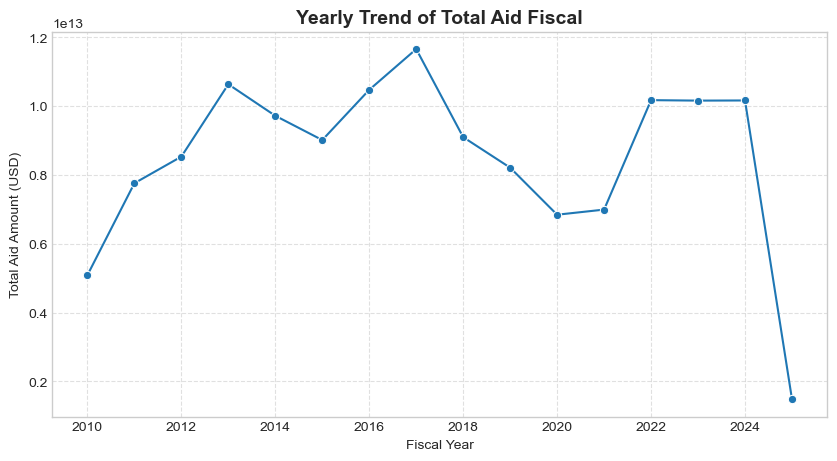

In [22]:
# ------- [Predictive Forecasting Preparation - Fixed] -------

# Define date and target columns
date_col = 'transaction_date'
target_col = 'total_aid_fiscal'  # try 'current_dollar_amount' or 'constant_dollar_amount' as well

# Ensure datetime format
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Aggregate data by fiscal year (or month if more granular)
time_series = (
    df.groupby('fiscal_year')[target_col]
      .sum()
      .reset_index()
      .sort_values('fiscal_year')
)

# Set fiscal_year as index
time_series = time_series.set_index('fiscal_year')

# Display sample
display(time_series.head())

# Plot baseline trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=time_series.index, y=target_col, data=time_series, marker='o')
plt.title(f"Yearly Trend of {target_col.replace('_', ' ').title()}", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

ARIMA Forecast Performance (Total Aid Fiscal)
MAE:  3,447,374,321,651.35
RMSE: 5,337,969,594,869.29


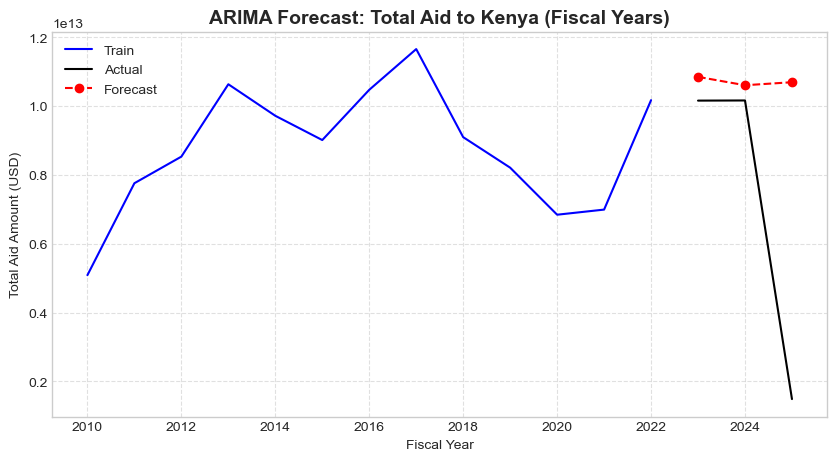

In [ ]:
# ------- [Baseline ARIMA Forecast - Total Aid Fiscal] -------

# Extract target time series
ts = time_series['total_aid_fiscal']

# Split into train and test (last 3 fiscal years for testing)
train = ts.iloc[:-3]
test = ts.iloc[-3:]

# Fit ARIMA model (baseline)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Evaluate model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--', marker='o')
plt.title("ARIMA Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

23:00:00 - cmdstanpy - INFO - Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast Performance (Total Aid Fiscal)
MAE:  3,776,568,081,080.20
RMSE: 4,475,886,959,496.08


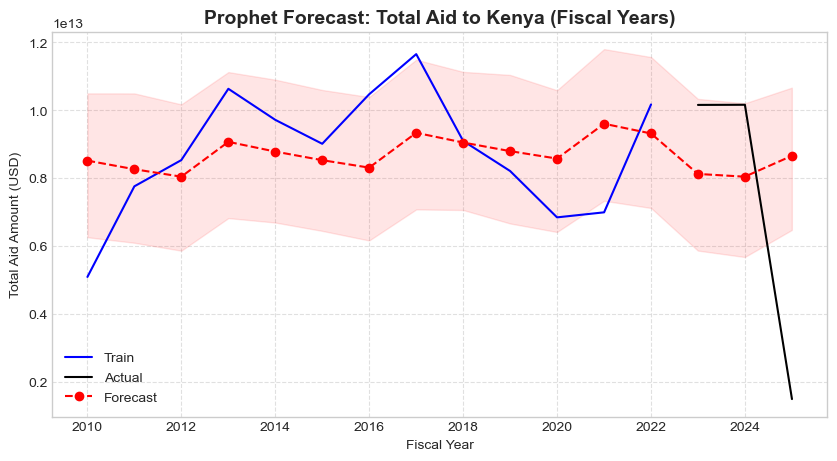

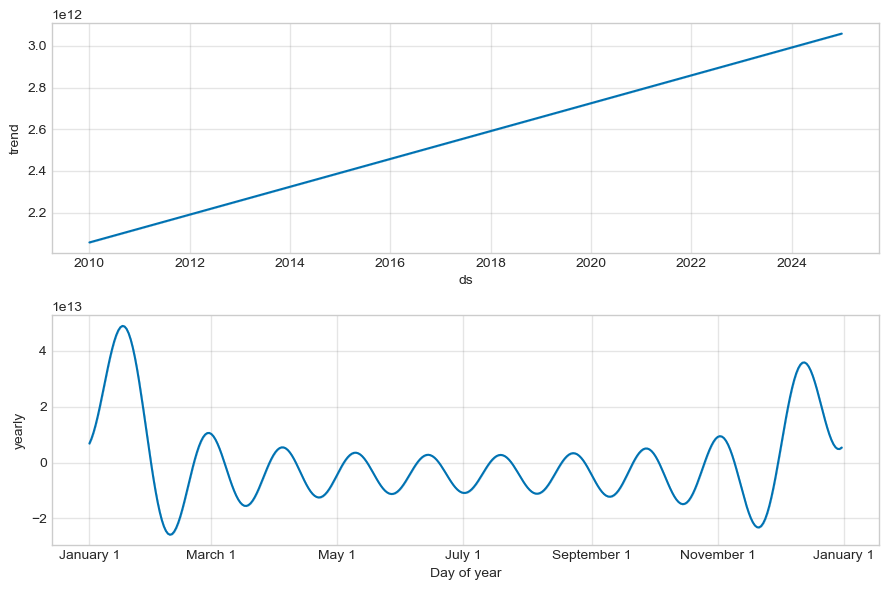

In [24]:
# ------- [Prophet Forecast - Total Aid Fiscal] -------

# Prepare data for Prophet
prophet_df = time_series.reset_index().rename(columns={'fiscal_year': 'ds', 'total_aid_fiscal': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Split into train and test (last 3 fiscal years)
train = prophet_df.iloc[:-3]
test = prophet_df.iloc[-3:]

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='additive'
)
model.fit(train)

# Create future dataframe by extending 3 years beyond test
future = model.make_future_dataframe(periods=3, freq='Y')
forecast = model.predict(future)

# Evaluate forecast by aligning dates
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
eval_df = pd.merge_asof(
    test.sort_values('ds'),
    forecast_df.sort_values('ds'),
    on='ds',
    direction='nearest'
)

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))

print("Prophet Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Actual', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)
plt.title("Prophet Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 7Trend and seasonality decomposition
model.plot_components(forecast)
plt.show()